In [32]:
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from highlight_text import HighlightText, ax_text, fig_text
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.patheffects as path_effects

In [33]:
data = pd.read_csv("PL 23-24 WS Events.csv" , low_memory=False)
data['x'] = data['x']*1.2
data['y'] = data['y']*.8
data['endX'] = data['endX']*1.2
data['endY'] = data['endY']*.8

In [34]:
def add_carries(game_df):
   min_dribble_length: float = 0.0
   max_dribble_length: float = 100.0
   max_dribble_duration: float = 20.0
   game_df['time_seconds']=game_df['minute']*60+game_df['second']
   next_actions = data.shift(-1)
   same_game=game_df.gameId==next_actions.gameId
   same_team = game_df.teamId == next_actions.teamId
   dx = game_df.endX - next_actions.x
   dy = game_df.endY- next_actions.y
   far_enough=dy** 2 + dy** 2 >= min_dribble_length** 2
   not_too_far = dx ** 2+ dy** 2<= max_dribble_length ** 2
   dt = next_actions.time_seconds - game_df.time_seconds
   same_phase = dt < max_dribble_duration
   same_period = game_df.period == next_actions.period
   dribble_idx = same_team & far_enough & not_too_far & same_phase & same_period&same_game
   dribbles = pd.DataFrame()
   prev = game_df[dribble_idx]
   nex= next_actions[dribble_idx]
   dribbles['gameId' ] = nex.gameId
   dribbles['period' ] = nex.period
   for cols in ['expandedMinute']:
      dribbles[cols] = nex[cols]
   for cols in ['passKey','assist']:
      dribbles[ cols] = [True for _ in range (len (dribbles))]
   dribbles['isTouch'] = [True for _ in range (len (dribbles))]
   morecols = ['playerId', 'team','player']
   for cols in morecols:
      dribbles[cols] = nex[cols]
   #dribbles['action_id'] = prev.eventId + 0.1
   dribbles['time_seconds' ] = (prev.time_seconds + nex.time_seconds) / 2
   dribbles['teamId'] = nex.teamId
   dribbles['playerId']= nex.playerId
   dribbles['player' ]= nex.player
   dribbles['x'] = prev.endX
   dribbles['y']= prev.endY
   dribbles['endX'] = nex.x
   dribbles['endY'] = nex.y
   dribbles['type'] = ['Carry' for _ in range(len(dribbles))]
   dribbles['outcomeType'] = ['Successful' for _ in range(len(dribbles))]
   dribbles['qualifiers']=[{} for _ in range(len(dribbles))]
   game_df=pd.concat([game_df,dribbles], ignore_index=True,sort=False)
   game_df=game_df.sort_values(['gameId','period']).reset_index(drop=True)
   game_df['action_id']=range(len(game_df))
   return game_df

In [35]:
data = add_carries(data)
data_carries = data[data['type'] == 'Carry']

In [36]:
data_passes = data[(data['type'] == 'Pass') & (data['outcomeType'] == 'Successful')]

In [37]:
# Define the Zone 14 coordinates
z14_x_min = 78
z14_x_max = 78 + 24
z14_y_min = 30
z14_y_max = 30 + 20



# Function to identify actions and calculate progressive actions starting inside the specified zone
def calculate_progressive_actions(df, x_min, x_max, y_min, y_max):
    df_prog = df.copy()
    df_prog['in_zone'] = (df_prog['x'].between(x_min, x_max) & df_prog['y'].between(y_min, y_max))
    df_prog['beginning'] = np.sqrt(np.square(120 - df_prog['x']) + np.square(40 - df_prog['y']))
    df_prog['end'] = np.sqrt(np.square(120 - df_prog['endX']) + np.square(40 - df_prog['endY']))
    df_prog['progressive'] = (df_prog['end'] / df_prog['beginning']) < 0.75
    return df_prog[df_prog['progressive'] & df_prog['in_zone']]

# Calculate progressive actions out of Zone 14
prog_z14_passes = calculate_progressive_actions(data_passes, z14_x_min, z14_x_max, z14_y_min, z14_y_max)
prog_z14_carries = calculate_progressive_actions(data_carries, z14_x_min, z14_x_max, z14_y_min, z14_y_max)

# Group and aggregate
z14_passes_grouped = prog_z14_passes.groupby(['playerId', 'player', 'team']).size().reset_index(name='z14_prog_passes')
z14_carries_grouped = prog_z14_carries.groupby(['playerId', 'player', 'team']).size().reset_index(name='z14_prog_carries')

# Merge and combine
combined_z14_prog_df = pd.merge(z14_passes_grouped, z14_carries_grouped, on=['playerId', 'player', 'team'], how='outer').fillna(0)

# Calculate total progressive actions and per 90 numbers
combined_z14_prog_df['total_prog_actions'] = combined_z14_prog_df['z14_prog_passes'] + combined_z14_prog_df['z14_prog_carries']

# Merge with player metadata (e.g., minutes played)
info = pd.read_csv("T5 Leagues Mins 23-24.csv")
info['90s'] = info['Mins'] / 90

# Merge with the main dataframe
combined_z14_prog_df = pd.merge(combined_z14_prog_df, info, on=['player', 'team'], how='left')
combined_z14_prog_df = combined_z14_prog_df[(combined_z14_prog_df['90s'] >= 15) & (combined_z14_prog_df['position'] != 'GK')
                                            ]

# Calculate per 90 values
combined_z14_prog_df['z14_prog_passes_p90'] = combined_z14_prog_df['z14_prog_passes'] / combined_z14_prog_df['90s']
combined_z14_prog_df['z14_prog_carries_p90'] = combined_z14_prog_df['z14_prog_carries'] / combined_z14_prog_df['90s']
combined_z14_prog_df['total_prog_actions_p90'] = combined_z14_prog_df['total_prog_actions'] / combined_z14_prog_df['90s']

# Get the top 12 players based on per 90 numbers
top_12_prog_z14 = combined_z14_prog_df.sort_values("total_prog_actions_p90", ascending=False).head(30)

top_12_prog_z14





,playerId,player,team,z14_prog_passes,z14_prog_carries,total_prog_actions,Unnamed: 0,age,position,Mins,Passing Accuracy,90s,z14_prog_passes_p90,z14_prog_carries_p90,total_prog_actions_p90
70,137015.0,James Maddison,Tottenham,28.0,5.0,33.0,21,27,AM(CLR),2155,87.4,23.944444,1.169374,0.208817,1.378190
89,247454.0,Martin Ødegaard,Arsenal,25.0,5.0,30.0,12,25,AM(CR),3104,86.8,34.488889,0.724871,0.144974,0.869845
215,369875.0,Dominik Szoboszlai,Liverpool,16.0,4.0,20.0,111,23,AM(CLR),2110,87.3,23.444444,0.682464,0.170616,0.853081
112,303139.0,Rodri,Man City,23.0,1.0,24.0,1,28,"D(C),DMC",2937,92.5,32.633333,0.704801,0.030644,0.735444
53,123761.0,Bruno Fernandes,Man Utd,25.0,0.0,25.0,9,29,"M(CLR),FW",3120,79.4,34.666667,0.721154,0.000000,0.721154
177,352825.0,Cody Gakpo,Liverpool,10.0,3.0,13.0,83,25,"AM(CLR),FW",1646,79.3,18.288889,0.546780,0.164034,0.710814
219,373525.0,João Pedro,Brighton,12.0,4.0,16.0,66,22,"AM(CL),FW",2046,82.7,22.733333,0.527859,0.175953,0.703812
243,400828.0,Darwin Núñez,Liverpool,11.0,5.0,16.0,75,25,"AM(CL),FW",2050,71.6,22.777778,0.482927,0.219512,0.702439
142,331254.0,Phil Foden,Man City,12.0,9.0,21.0,4,24,"AM(CLR),FW",2869,89.1,31.877778,0.376438,0.282328,0.658766
160,338780.0,Bruno Guimarães,Newcastle,21.0,1.0,22.0,11,26,DMC,3269,85,36.322222,0.578158,0.027531,0.605690


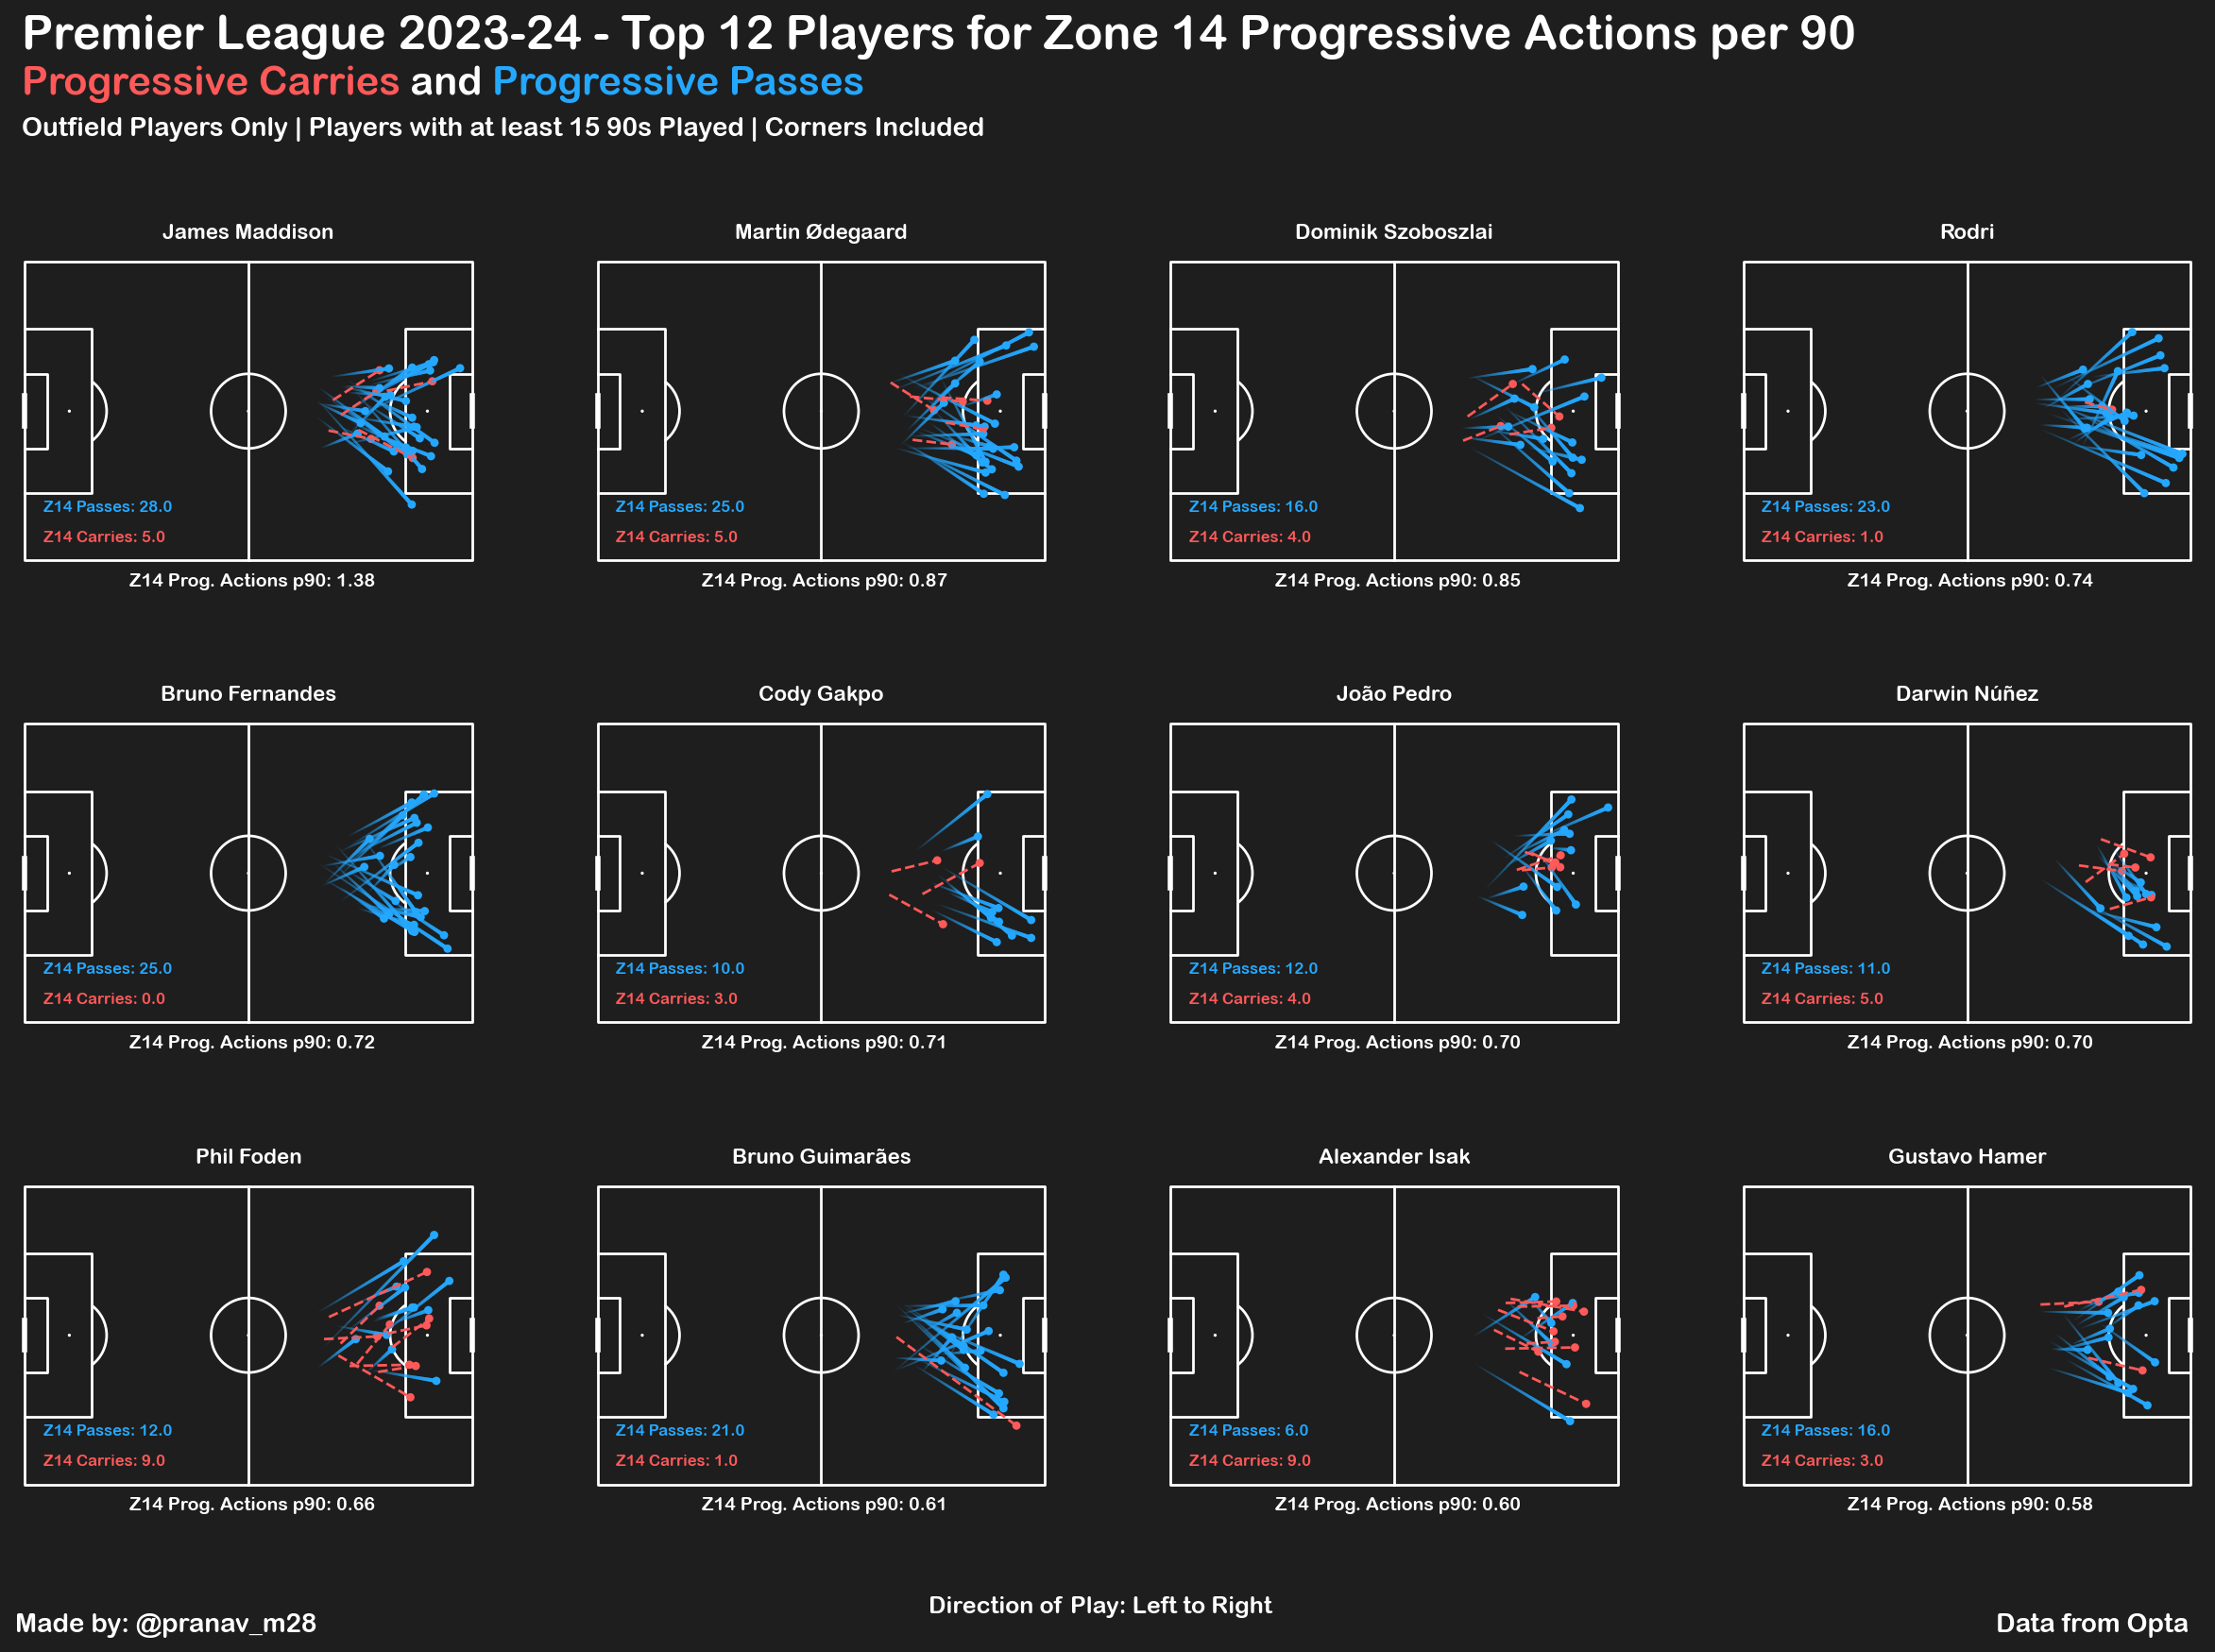

In [48]:
fig, axs = plt.subplots(3, 4, figsize=(30, 18))
fig.set_facecolor('#1e1e1e')

# Define the title and additional text
fig_text(0.453, 1.00, "Premier League 2023-24 - Top 12 Players for Zone 14 Progressive Actions per 90", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=36, fontweight='bold')
fig_text(0.278, 0.97, "<Progressive Carries> and <Progressive Passes>", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=30, fontweight='bold', highlight_textprops=[{"color": '#FF5959'}, {"color": '#24A8FF'}])
fig_text(0.299, 0.94, "Outfield Players Only | Players with at least 15 90s Played | Corners Included", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=20, fontweight='bold')

for ax, (_, player_data) in zip(axs.flatten(), top_12_prog_z14.iterrows()):
    player_id = player_data['playerId']
    player_name = player_data['player']
    
    player_prog_z14_passes = prog_z14_passes[prog_z14_passes['playerId'] == player_id]
    player_prog_z14_carries = prog_z14_carries[prog_z14_carries['playerId'] == player_id]
    
    pitch = Pitch(pitch_type='statsbomb', pitch_color='#1e1e1e', line_color='#FFFFFF')
    pitch.draw(ax=ax)
    
    # Plot Zone 14 Progressive Passes
    pitch.lines(player_prog_z14_passes.x, player_prog_z14_passes.y, player_prog_z14_passes.endX, player_prog_z14_passes.endY,
                lw=3, transparent=True, comet=True, color='#24a8ff', ax=ax)
    pitch.scatter(player_prog_z14_passes.endX, player_prog_z14_passes.endY, s=40, marker='o', edgecolors='none', c='#24a8ff', ax=ax, alpha=1)
    
    # Plot Zone 14 Progressive Carries
    pitch.lines(player_prog_z14_carries.x, player_prog_z14_carries.y, player_prog_z14_carries.endX, player_prog_z14_carries.endY, 
                ls='dashed', lw=2, transparent=False, comet=False, color='#FF5959', ax=ax)
    pitch.scatter(player_prog_z14_carries.endX, player_prog_z14_carries.endY, s=40, marker='o', edgecolors='none', c='#FF5959', ax=ax, alpha=1)
    
    ax.invert_yaxis()
    ax.set_title(f'{player_name}', font='Arial Rounded MT Bold', color='#FFFFFF', fontsize=16)
    
    ax.text(5, 5, f'Z14 Carries: {player_data["z14_prog_carries"]}', color='#FF5959', font='Arial Rounded MT Bold', fontsize=12, ha='left')
    ax.text(5, 13, f'Z14 Passes: {player_data["z14_prog_passes"]}', font='Arial Rounded MT Bold', color='#24A8FF', fontsize=12, ha='left')
    ax.text(28, -7, f'Z14 Prog. Actions p90: {player_data["total_prog_actions_p90"]:.2f}', font='Arial Rounded MT Bold', color='#FFFFFF', fontsize=14, ha='left')

    
    
fig_text(0.18, 0.06, "Made by: @pranav_m28", ha="center", font='Arial Rounded MT Bold' ,color="#FFFFFF", fontsize=20, fontweight='bold')
fig_text(0.86, 0.06, "Data from Opta", ha="center", font='Arial Rounded MT Bold' ,color="#FFFFFF", fontsize=20, fontweight='bold')


fig_text(
    0.510, 0.070, "Direction of Play: Left to Right", font='Arial Rounded MT Bold' , size=18,
    ha="center", color="#FFFFFF" , fontweight='bold'
)

#plt.savefig("Z14_Prog_Out_PL.png" , dpi=300, bbox_inches='tight')    
    
plt.show()